# Lab 2.3: More Hypothesis Testing
---

## Type II Error and Power

**What is the Type II error and Power for your test on the mean from Lab 2.2?**

In this case, we will assume that true mean has increased by 30% (true mean is 1.3 times the early mean), and that the pooled standard deviation has increased by 10% (true pooled standard deviation is 1.1 times $\sigma'$, where $\sigma'$ is our test estimate of pooled estimator for the two observed data sets).

In [10]:
# import libraries we'll need
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
# Read the excel file
skykomish_data_file = '../data/Skykomish_peak_flow_12134500_skykomish_river_near_gold_bar.xlsx'
skykomish_data = pd.read_excel(skykomish_data_file)
# Preview our data
skykomish_data.head(3)

,date of peak,water year,peak value (cfs),gage_ht (feet)
0,1928-10-09,1929,18800,10.55
1,1930-02-05,1930,15800,10.44
2,1931-01-28,1931,35100,14.08


In [12]:
# Divide the data into the early period (before 1975) and late period (after and including 1975).
skykomish_before = skykomish_data[ skykomish_data['water year'] < 1975 ] 
skykomish_after = skykomish_data[ skykomish_data['water year'] >= 1975 ] 

---
### Calculate Type II error and Power
Recall from the class lectures that the Type II error, $\beta$, is the probability that we would incorrectly conclude that a change in the probability distribution had NOT taken place, if in fact a change of a certain assumed magnitude had occurred (failure to reject a false null hypothesis). 

Type II error is a function of both $\alpha$ (expressed in the equation below with $z_{\alpha}$), and the posited true nature of the probability distribution we are hoping to detect (we get to decide how different the true probability distribution is from the null hypothesis, and then see how likely we would be to make a mistake).  


${ \beta = P\big((\overline{X}-\overline{Y}) < \Delta_0 + z_{\alpha}\sigma'\big)}$

where $\sigma'$ is the pooled standard deviation from $\overline{X}$ (the later period) and $\overline{Y}$ (the earlier period):

$\sigma' = \displaystyle\sqrt{ \displaystyle\frac{s^2_X}{n_X} + \displaystyle\frac{s^2_Y}{n_Y} }$


Power, $(1-\beta)$, is the probability that we would correctly conclude that a change in the probability distribution had taken place, given a certain assumed magnitude change had occurred.

If we assume a true normal distribution with mean $(\overline{X}-\overline{Y}) = \Delta^* = 0.3\cdot\overline{Y}$ 

and a true standard deviation $\sigma^* = 1.1\cdot\sigma'$

then we need to solve for the intersection of $ \Delta^* + z_{eff}\sigma^* = \Delta_0 + z_{\alpha}\sigma'$

In [17]:
# Get the length of our two datasets
nX = len(skykomish_after)
nY = len(skykomish_before)

# Set our alpha and confidence
alpha = 0.05
conf = 1 - alpha

# Calculate z_alpha from a normal distribution
z_alpha = stats.norm.ppf(conf)

# Get our means
meanX = skykomish_after['peak value (cfs)'].mean()
meanY = skykomish_before['peak value (cfs)'].mean()

# Get our standard deviations
sdX = skykomish_after['peak value (cfs)'].std(ddof=1)
sdY = skykomish_before['peak value (cfs)'].std(ddof=1)

# Calculate the pooled standard deivation
sigma_prime = np.sqrt(sdX**2/nX + sdY**2/nY)

# For our null hypothesis PDF
delta_0 = 0

# Set our expected change in the mean (30% of early period mean)
delta_star = .3 * meanY

# Set our expected change in the standard deviation (1.1 times the pooled standard deviation)
sigma_star = 1.1 * sigma_prime

# Rearranging the equation above to solve for the "z effective" value, the z value on our postulated "true" PDF
z_eff = ((delta_0 + z_alpha*sigma_prime) - delta_star) / sigma_star

# Look up the cdf value of the postulated true distribution at this point to get our beta vlaue
beta = stats.norm.cdf(z_eff)
print("Type II error: {}".format(np.round(beta,4)))

# Thus, our confidence that we are not commiting Type II error is
power = 1 - beta
print("Power: {}".format(np.round(power,4)))

Type II error: 0.2547
Power: 0.7453


Compute the two-sample z-test value:

$ztest = \displaystyle\frac{(\bar{X}-\bar{Y})-\Delta_0}{\sigma'}$

In [129]:
z_test = ((meanX - meanY) - delta_0) / sigma_prime
print("z-test = {}".format(np.round(z_test,2)))

p = 1 - st.norm.cdf(z_test)
print("p = {}".format(np.round(p,4)))

z-test = 2.71
p = 0.0033


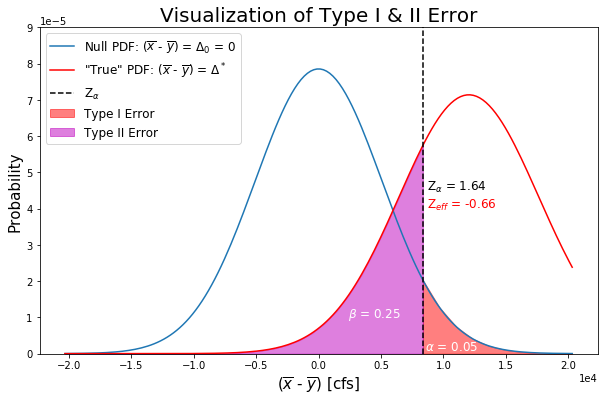

In [127]:
# Make a plot
plt.figure(figsize=(10,6))

# Create values for z
z = np.linspace(-4, 4, num=160)
z = [i * sigma_prime for i in x]
    
# Plot the Null PDF
plt.plot(z, st.norm.pdf(z, delta_0, sigma_prime), label='Null PDF: ($\overline{x}$ - $\overline{y}$) = $\Delta_0$ = 0')

# Plot the postulated True PDF
plt.plot(z, st.norm.pdf(z, delta_star, sigma_star), color='red', label=r'"True" PDF: ($\overline{x}$ - $\overline{y}$) = $\Delta^*$')

# Plot where z_alpha is
plt.axvline(z_alpha*sigma_prime, color='black', linestyle='--', label=r'Z$_\alpha$')
# Add labels here with z_alpha and z_eff values
plt.text(z_alpha*sigma_prime+300, 4e-5, r'Z$_{eff}$ = ' + str(round(z_eff,2)),fontsize=12, color='r')
plt.text(z_alpha*sigma_prime+300, 4.5e-5, r'Z$_{\alpha}$ = ' + str(round(z_alpha,2)),fontsize=12, color='k')

# Plot where z_test is
#plt.axvline(z_test*sigma_prime, color='k', linestyle=':', label=r'z-test')
# Add labels here with z_test
#plt.text(z_test*sigma_prime+300, 1e-5, r'z-test = ' + str(round(z_test,2)),fontsize=12, color='k')

# Shade in the Type I Error area
shade = np.linspace(z_alpha*sigma_prime, np.max(z), 10)
plt.fill_between(shade, st.norm.pdf(shade, delta_0, sigma_prime) ,  color='red', alpha=0.5, label='Type I Error')
# Add label here with alpha value
plt.text(z_alpha*sigma_prime+200, 0.1e-5, r'$\alpha$ = ' + str(round(alpha,2)),fontsize=12, color='w')

# Shade in the Type II Error area
shade = np.linspace(np.min(z),z_alpha*sigma_prime, 30)
plt.fill_between(shade, st.norm.pdf(shade, delta_star, sigma_star) ,  color='m', alpha=0.5, label='Type II Error')
# Add label here with Beta value
plt.text(z_alpha*sigma_prime-6000, 1e-5, r'$\beta$ = ' + str(round(beta,2)),fontsize=12, color='w')

# Add title, legend, and labels
plt.title('Visualization of Type I & II Error',fontsize=20)
plt.xlabel('($\overline{x}$ - $\overline{y}$) [cfs]', fontsize=15)
plt.ylabel('Probability',fontsize=15)
plt.ylim(0, 9e-5)
plt.ticklabel_format(axis='both', style='sci', scilimits=(0,0))
plt.legend(loc='upper left',fontsize=12);

---
# Wilcoxan Rank Sum Test

* Note that the scipy.stats library has Wilcoxan Rank Sum function, read the documentation for [scipy.stats.ranksums](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ranksums.html)
* Test the significance of the change in the mean between the two sample periods using the two-sample Wilcoxan Rank Sum test. 
* Then answer: **How different is your conclusion from the one we just did (i.e. compare P for the two tests)?** Only consider the case where the null hypothesis is no change.

In [145]:
z_wilcoxan, p_wilcoxan = stats.ranksums(skykomish_after['peak value (cfs)'], skykomish_before['peak value (cfs)'])

print("Z from stats.ranksums: {}".format(np.round(z_wilcoxan,4)))
print("P from stats.ranksums: {}".format(np.round(p_wilcoxan,4)))

Z from stats.ranksums: 2.7553
P from stats.ranksums: 0.0059


This returns z_wilxocan, the test statistic z presuming this is a large enough sample that this is normally distributed, and p_wilcoxan, the **two-sided** p-value of the test.

Note that we are doing a **one-sided** test, so how should we interpret the two-sided p-value?

If we look up the z score corresponding to that p-value, what do we get?

In [142]:
print("Z from looking up (1-P): {}".format(np.round(stats.norm.ppf(1-p_wilcoxan),4)))

Z from looking up (1-P): 2.5202


Why is this different from the p value that the Wilcoxan test gave us? And how do I know which one to use?

In [144]:
one_sided_p = 1 - st.norm.cdf(z_wilcoxan)
print("One-sided P value: {}".format(np.round(one_sided_p,4)))
print("Two-sided P value: {}".format(np.round(2*one_sided_p,4)))

One-sided P value: 0.0029
Two-sided P value: 0.0059


Based on the above, do you understand what the two outputs of the function are showing, and do you now understand which we should use in this case?  

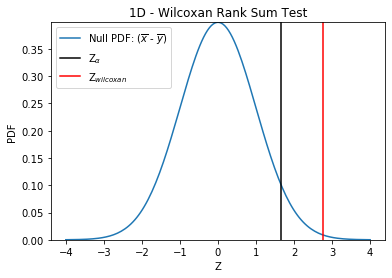

In [147]:
# Plot

plt.figure(1)

z = np.linspace(-4, 4, num=160)

plt.plot(z, st.norm.pdf(z), label='Null PDF: ($\overline{x}$ - $\overline{y}$)')
plt.axvline(z_alpha, color='black', label=r'Z$_\alpha$')
plt.axvline(z_wilcoxan, color='red', label=r'Z$_{wilcoxan}$')
plt.title('1D - Wilcoxan Rank Sum Test')
plt.xlabel('Z')
plt.ylabel('PDF')
plt.ylim(0, max(st.norm.pdf(z)))
plt.legend(loc='best')

## Change in the Standard Deviation
Test for statistical significance of a change in the standard deviation.
Note that the standard deviation does not benefit from the Central Limit Theorem.
Even though it is not strictly true, assume for the moment that the
sample data are derived from a normally distributed population.  Use a
single sample test (with rejection region based on the Chi Squared
distribution). Assume that the sample standard deviation from the
1929-1974 data is close to the true population standard deviation of the
earlier data set. Test that the more recent sample is different from this.

Use ${t} = \frac{(n-1)s^2}{\sigma^2}$ with n-1 degrees of freedom.

In [10]:
# first calculate the test statistic
sd1 = stats.stdev(early) #we pretend this is the "true population standard deviation)
sd2 = stats.stdev(late)
m = len(late)
t = (m-1)*sd2**2/sd1**2
print(t)

54.98281571318139


In [11]:
# Now, we know from the lecture notes that this test statistic is a chi-squared distributed
# with n-1 degrees of freedom.  We assume we want 95% confidence that there is a change 
# and therefore alpha = 0.05.  Also note that this just a test for a change (there's no one-sided
# or two-sided questions to worry about here)
# How do we look this up in python?
st.chi2.ppf?

In [12]:
alpha = 0.05
vals = st.chi2.ppf(alpha, m-1)
print(vals)

20.86653399071479


### Our t statistic is larger than the cut-off value from the chi-squared distribution, so we determine that yes, with 95% confidence, a change has occurred.